<a href="https://www.kaggle.com/code/dataranch/ru-ua-tweets-feature-importance-eda?scriptVersionId=107370831" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**🇷🇺RU 🇺🇦UA Tweets Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

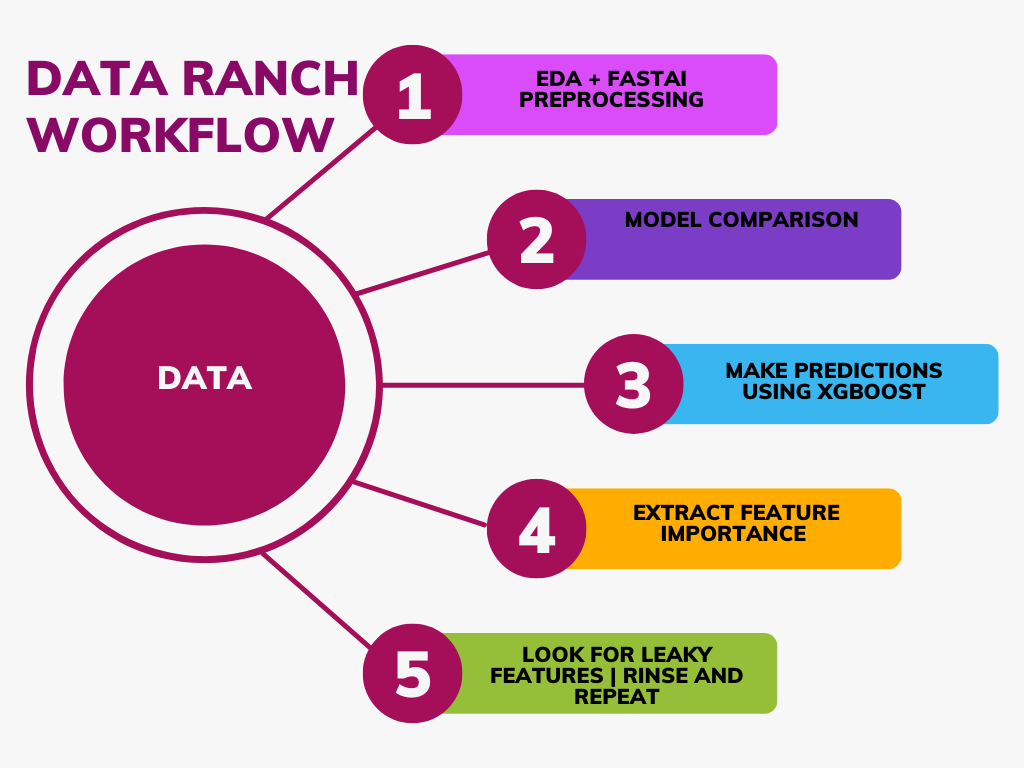

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 515.0 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil


In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'russiaukraine-conflict-twitter-dataset'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/russiaukraine-conflict-twitter-dataset
CSV!


In [12]:
df.head(1)

Datetime             Tweet Id  \
0  2022-02-24 03:12:47+00:00  1496684505247141897   

                                                                                                                               Text  \
0  🇺🇦 Massive explosions rocks #Kharkiv. #Russia #Ukraine #UkraineWar #RussiaWar #Europe #EU #NATO #US [29] https://t.co/tpTeuYSufO   

       Username                                                    Permalink  \
0  IdeologyWars  https://twitter.com/IdeologyWars/status/1496684505247141897   

                               User Outlinks CountLinks  ReplyCount  \
0  https://twitter.com/IdeologyWars      NaN        NaN           2   

   RetweetCount  LikeCount  QuoteCount       ConversationId Language  \
0            17         47           1  1496493071495987201       en   

                                                                    Source  \
0  <a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>   

                                                                                                                                                                  Media  \
0  [Photo(previewUrl='https://pbs.twimg.com/media/FMVKIpSWQAIxO4T?format=png&name=small', fullUrl='https://pbs.twimg.com/media/FMVKIpSWQAIxO4T?format=png&name=large')]   

  QuotedTweet MentionedUsers  \
0         NaN            NaN   

                                                                                               hashtag  \
0  ['#Kharkiv.', '#Russia', '#Ukraine', '#UkraineWar', '#RussiaWar', '#Europe', '#EU', '#NATO', '#US']   

   hastag_counts  
0              9

In [13]:
df.isna().sum()

Datetime             0
Tweet Id             0
Text                 0
Username             0
Permalink            0
User                 0
Outlinks          1041
CountLinks        1041
ReplyCount           0
RetweetCount         0
LikeCount            0
QuoteCount           0
ConversationId       0
Language             0
Source               0
Media             1327
QuotedTweet       1672
MentionedUsers    1642
hashtag              0
hastag_counts        0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

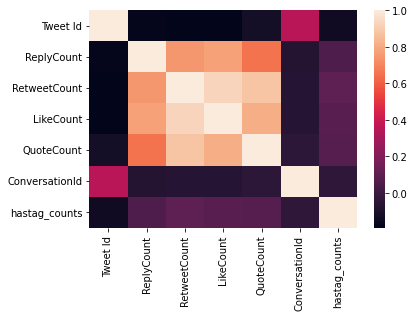

In [15]:
sns.heatmap(df.corr())

In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [17]:
df.columns

Index(['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User',
       'Outlinks', 'CountLinks', 'ReplyCount', 'RetweetCount', 'LikeCount',
       'QuoteCount', 'ConversationId', 'Language', 'Source', 'Media',
       'QuotedTweet', 'MentionedUsers', 'hashtag', 'hastag_counts'],
      dtype='object')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**More EDA 📊**</div>

In [18]:
def get_first_hashtag(hashtag_list):
    try:
        first_hashtag = hashtag_list.strip('][').split(', ')[0].replace('.','')
    except Exception:
        first_hashtag = ''
    return first_hashtag

In [19]:
df['first_hashtag'] = df['hashtag'].apply(get_first_hashtag)

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 10 Hashtags**</div>

In [20]:
hashtag = df['first_hashtag'].value_counts()[:10]
fig = px.bar(x=hashtag.index,y=hashtag.values,text=hashtag.values,
       color = hashtag.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribution of Top 10 Hashtags')
us,uk = [1,3,4,6],[0,2,5,8]

for idx in us:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "crimson"
for idx in uk:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "blue"
fig.show()

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Author Distribution**</div>

In [21]:
sentiment = df["Username"].value_counts().sort_values(ascending=False).iloc[0:10]
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Tweeters Pie Graph",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [22]:
def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [23]:
# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
def whole_string(sent):
    all_str = get_all_str(sent)
    words = get_word(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 20 Terms**</div>

In [25]:
freq_df = whole_string(df['Text'])
top_10 = freq_df[:20]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, title = 'Rank of terms')

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

Target Variable: hastag_counts
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
25
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not c

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.00332657863291419, 'Adjusted R-Squared': -0.01605914942774822, 'RMSE': 3.036109782028976, 'Time taken': 0.050580739974975586}


 19%|█▉        | 8/42 [00:00<00:00, 36.55it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.15721674305543365, 'Adjusted R-Squared': 0.14652152405867513, 'RMSE': 2.782622305461614, 'Time taken': 0.04053330421447754}
{'Model': 'BayesianRidge', 'R-Squared': 0.0004655769427704959, 'Adjusted R-Squared': -0.012218870050341613, 'RMSE': 3.030366736617202, 'Time taken': 0.02748703956604004}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.006944930606984756, 'Adjusted R-Squared': -0.0056572910858201375, 'RMSE': 3.0205287855839726, 'Time taken': 0.014233112335205078}
{'Model': 'DummyRegressor', 'R-Squared': -0.027415647041056035, 'Adjusted R-Squared': -0.04045391667355691, 'RMSE': 3.072340885322623, 'Time taken': 0.008982658386230469}
{'Model': 'ElasticNet', 'R-Squared': -0.027415647041056035, 'Adjusted R-Squared': -0.04045391667355691, 'RMSE': 3.072340885322623, 'Time taken': 0.011150121688842773}
{'Model': 'ElasticNetCV', 'R-Squared': -0.0062230645353504865, 'Adjusted R-Squared': -0.018992392765494692, 'RMSE': 3.040489069724159, 'Time ta

 29%|██▊       | 12/42 [00:00<00:02, 10.15it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -12717.387775272326, 'Adjusted R-Squared': -12878.788635364615, 'RMSE': 341.8317069063912, 'Time taken': 0.39385294914245605}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.09271515863968893, 'Adjusted R-Squared': 0.08120139161734985, 'RMSE': 2.887141969407414, 'Time taken': 0.13380074501037598}


 36%|███▌      | 15/42 [00:01<00:03,  8.79it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.15128754319141158, 'Adjusted R-Squared': 0.14051708054155632, 'RMSE': 2.7923933866278987, 'Time taken': 0.4049568176269531}
{'Model': 'HuberRegressor', 'R-Squared': 0.014621985832870443, 'Adjusted R-Squared': 0.0021171886987697563, 'RMSE': 3.0088306644540643, 'Time taken': 0.016477108001708984}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.019221977926290434, 'Adjusted R-Squared': 0.006775556326370169, 'RMSE': 3.001799460323757, 'Time taken': 0.013906240463256836}


 48%|████▊     | 20/42 [00:01<00:01, 11.08it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.0808716612367, 'Adjusted R-Squared': -3.1326593726737144, 'RMSE': 6.123120144211288, 'Time taken': 0.188370943069458}
{'Model': 'Lars', 'R-Squared': -0.008498532895262034, 'Adjusted R-Squared': -0.021296737627435558, 'RMSE': 3.0439250025455507, 'Time taken': 0.031250953674316406}
{'Model': 'LarsCV', 'R-Squared': -0.008498532895262034, 'Adjusted R-Squared': -0.021296737627435558, 'RMSE': 3.0439250025455507, 'Time taken': 0.03759765625}
{'Model': 'Lasso', 'R-Squared': -0.027415647041056035, 'Adjusted R-Squared': -0.04045391667355691, 'RMSE': 3.072340885322623, 'Time taken': 0.016230344772338867}
{'Model': 'LassoCV', 'R-Squared': -0.008330137912898161, 'Adjusted R-Squared': -0.02112620565290957, 'RMSE': 3.0436708608292324, 'Time taken': 0.06897687911987305}
{'Model': 'LassoLars', 'R-Squared': -0.027415647041056035, 'Adjusted R-Squared': -0.04045391667355691, 'RMSE': 3.072340885322623, 'Time taken': 0.011900186538696289}
{'Model': 'LassoLarsCV', 'R-

 62%|██████▏   | 26/42 [00:03<00:03,  5.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.010178219056298232, 'Adjusted R-Squared': -0.0023829710572005336, 'RMSE': 3.015607505999772, 'Time taken': 1.7656223773956299}


 67%|██████▋   | 28/42 [00:03<00:02,  5.57it/s]

{'Model': 'NuSVR', 'R-Squared': 0.03327476911745497, 'Adjusted R-Squared': 0.021006682431128132, 'RMSE': 2.980216667661983, 'Time taken': 0.20152688026428223}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.023893675249327506, 'Adjusted R-Squared': -0.03688724980832925, 'RMSE': 3.0670703858871042, 'Time taken': 0.011197328567504883}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.012882265562963457, 'Adjusted R-Squared': -0.025736101420361646, 'RMSE': 3.050533482299968, 'Time taken': 0.01665472984313965}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.4470438197042508, 'Adjusted R-Squared': -0.46540731995430495, 'RMSE': 3.646172018590296, 'Time taken': 0.012438774108886719}
{'Model': 'PoissonRegressor', 'R-Squared': 0.008742951275433675, 'Adjusted R-Squared': -0.0038364528961980504, 'RMSE': 3.0177930693558297, 'Time taken': 0.012340545654296875}


 79%|███████▊  | 33/42 [00:38<00:25,  2.78s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.006269455992934159, 'Adjusted R-Squared': -0.019039372947159405, 'RMSE': 3.040559159100425, 'Time taken': 34.140106439590454}
{'Model': 'RANSACRegressor', 'R-Squared': -0.4985188211489944, 'Adjusted R-Squared': -0.5175355574579918, 'RMSE': 3.710457090093385, 'Time taken': 0.1186988353729248}


 83%|████████▎ | 35/42 [00:38<00:14,  2.14s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.13134275397603812, 'Adjusted R-Squared': 0.12031918486405879, 'RMSE': 2.825013554325102, 'Time taken': 0.24065232276916504}
{'Model': 'Ridge', 'R-Squared': -0.008372194468761363, 'Adjusted R-Squared': -0.021168795921410632, 'RMSE': 3.043734334573617, 'Time taken': 0.011628150939941406}
{'Model': 'RidgeCV', 'R-Squared': -0.007276810679752055, 'Adjusted R-Squared': -0.020059511322896295, 'RMSE': 3.042080697555401, 'Time taken': 0.013865232467651367}
{'Model': 'SGDRegressor', 'R-Squared': -0.011090046432580936, 'Adjusted R-Squared': -0.02392113839238541, 'RMSE': 3.0478334423971885, 'Time taken': 0.018326997756958008}


 90%|█████████ | 38/42 [00:38<00:05,  1.44s/it]

{'Model': 'SVR', 'R-Squared': 0.05371077227663568, 'Adjusted R-Squared': 0.04170202573192283, 'RMSE': 2.948548397226275, 'Time taken': 0.2348484992980957}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.008498532895262478, 'Adjusted R-Squared': -0.021296737627436002, 'RMSE': 3.043925002545551, 'Time taken': 0.012114763259887695}
{'Model': 'TweedieRegressor', 'R-Squared': 0.007038661333403473, 'Adjusted R-Squared': -0.005562370883177792, 'RMSE': 3.020386234054428, 'Time taken': 0.010974407196044922}


100%|██████████| 42/42 [00:39<00:00,  1.07it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.029448830814309046, 'Adjusted R-Squared': 0.017132191611444858, 'RMSE': 2.9861083, 'Time taken': 0.46834731101989746}
{'Model': 'LGBMRegressor', 'R-Squared': 0.14174972671293262, 'Adjusted R-Squared': 0.13085822578289363, 'RMSE': 2.808039985612314, 'Time taken': 0.18280720710754395}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: hastag_counts
hastag_counts
Target Standard Deviation: 3.2488838828703925
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BaggingRegressor                             0.15       0.16   2.78   
HistGradientBoostingRegressor                0.14       0.15   2.79   
LGBMRegressor                                0.13       0.14   2.81   
RandomForestRegressor                        0.12       0.13   2.83   
GradientBoostingRegressor                    0.08       0.09   2.89   
ExtraTree

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.359408140182495.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       6.80
1       7       4.76
2       3       6.17
3       5       6.00
4       2       4.32
XGBoost RMSE:  2.9859536


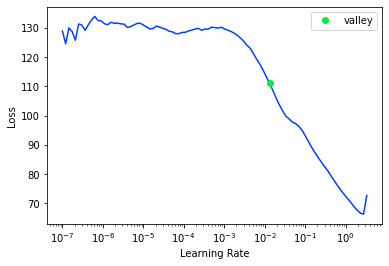

<Figure size 720x720 with 0 Axes>

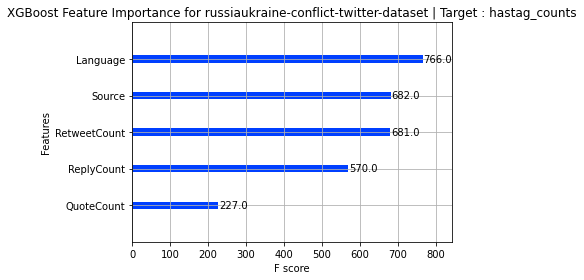

Target Variable: ConversationId
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
24
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not convert Outlinks_n

 10%|▉         | 4/42 [00:00<00:01, 36.06it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -19.77108751715565, 'Adjusted R-Squared': -20.088203357112224, 'RMSE': 5244076642368106.0, 'Time taken': 0.028464794158935547}
{'Model': 'BaggingRegressor', 'R-Squared': -3.9291758143731768, 'Adjusted R-Squared': -4.004430406959027, 'RMSE': 2554621523600785.5, 'Time taken': 0.045300960540771484}
{'Model': 'BayesianRidge', 'R-Squared': -0.0072372396657744975, 'Adjusted R-Squared': -0.022614907446931287, 'RMSE': 1154796076274081.2, 'Time taken': 0.01722121238708496}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -22.30602797975611, 'Adjusted R-Squared': -22.661845200821087, 'RMSE': 5554865454193747.0, 'Time taken': 0.019580364227294922}
{'Model': 'DummyRegressor', 'R-Squared': -0.007228185942113052, 'Adjusted R-Squared': -0.022605715498481116, 'RMSE': 1154791000000000.0, 'Time taken': 0.01529383659362793}
{'Model': 'ElasticNet', 'R-Squared': 0.04742978715716761, 'Adjusted R-Squared': 0.0328867304725442, 'RMSE': 1123021086562945.6, 'Time taken'

 19%|█▉        | 8/42 [00:00<00:01, 27.31it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.007237239665244255, 'Adjusted R-Squared': -0.02261490744639305, 'RMSE': 1154796076273777.2, 'Time taken': 0.09954690933227539}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -14.54119368024598, 'Adjusted R-Squared': -14.77846381276882, 'RMSE': 4536089333118347.0, 'Time taken': 0.019039630889892578}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -15.237739213119863, 'Adjusted R-Squared': -15.485643628587344, 'RMSE': 4636627359645919.0, 'Time taken': 0.29582905769348145}
{'Model': 'GammaRegressor', 'R-Squared': 0.02880964317917467, 'Adjusted R-Squared': 0.013982309487253652, 'RMSE': 1133943963128793.8, 'Time taken': 0.0171205997467041}


 26%|██▌       | 11/42 [00:01<00:03,  8.56it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -92133.20980333835, 'Adjusted R-Squared': -93539.83896064122, 'RMSE': 3.492608207222852e+17, 'Time taken': 0.41707563400268555}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.04160662204520005, 'Adjusted R-Squared': 0.026974662076424405, 'RMSE': 1126448431513328.0, 'Time taken': 0.15801763534545898}


 31%|███       | 13/42 [00:01<00:04,  6.21it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -3.4737436832143267, 'Adjusted R-Squared': -3.5420451134924082, 'RMSE': 2433744379619826.0, 'Time taken': 0.3991692066192627}
{'Model': 'HuberRegressor', 'R-Squared': -1695632.918832487, 'Adjusted R-Squared': -1721520.4595780212, 'RMSE': 1.4983230483500751e+18, 'Time taken': 0.027048349380493164}
{'Model': 'KNeighborsRegressor', 'R-Squared': -4.40635128797831, 'Adjusted R-Squared': -4.48889100229859, 'RMSE': 2675417300000000.0, 'Time taken': 0.025710105895996094}


 45%|████▌     | 19/42 [00:01<00:02, 10.06it/s]

{'Model': 'KernelRidge', 'R-Squared': -1695539.7972354535, 'Adjusted R-Squared': -1721425.9162772163, 'RMSE': 1.4982819049908636e+18, 'Time taken': 0.16019964218139648}
{'Model': 'Lars', 'R-Squared': 0.054515737435610334, 'Adjusted R-Squared': 0.040080863197986094, 'RMSE': 1118836342176376.8, 'Time taken': 0.02888941764831543}
{'Model': 'LarsCV', 'R-Squared': 0.020335533713515597, 'Adjusted R-Squared': 0.005378824304561602, 'RMSE': 1138880325497619.0, 'Time taken': 0.05782294273376465}
{'Model': 'Lasso', 'R-Squared': 0.05451573743561178, 'Adjusted R-Squared': 0.04008086319798754, 'RMSE': 1118836342176375.9, 'Time taken': 0.03477644920349121}


 60%|█████▉    | 25/42 [00:02<00:01, 14.60it/s]

{'Model': 'LassoCV', 'R-Squared': 0.021425399800877543, 'Adjusted R-Squared': 0.006485329568829856, 'RMSE': 1138246653208733.0, 'Time taken': 0.15429234504699707}
{'Model': 'LassoLars', 'R-Squared': 0.054515737435611666, 'Adjusted R-Squared': 0.040080863197987426, 'RMSE': 1118836342176376.0, 'Time taken': 0.03191518783569336}
{'Model': 'LassoLarsCV', 'R-Squared': 0.020335533713515597, 'Adjusted R-Squared': 0.005378824304561602, 'RMSE': 1138880325497619.0, 'Time taken': 0.05518841743469238}
{'Model': 'LassoLarsIC', 'R-Squared': 0.023411959978232533, 'Adjusted R-Squared': 0.00850221890919789, 'RMSE': 1137090714649285.8, 'Time taken': 0.01765751838684082}
{'Model': 'LinearRegression', 'R-Squared': 0.054515737435610334, 'Adjusted R-Squared': 0.040080863197986094, 'RMSE': 1118836342176376.8, 'Time taken': 0.014707088470458984}
{'Model': 'LinearSVR', 'R-Squared': -1695632.918832494, 'Adjusted R-Squared': -1721520.4595780282, 'RMSE': 1.4983230483500782e+18, 'Time taken': 0.01543426513671875}


 71%|███████▏  | 30/42 [00:03<00:01,  8.58it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.007918921585802985, 'Adjusted R-Squared': -0.007227354420520582, 'RMSE': 1146074885652478.8, 'Time taken': 0.016321420669555664}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.007918921585802985, 'Adjusted R-Squared': -0.007227354420520582, 'RMSE': 1146074885652478.8, 'Time taken': 0.020558834075927734}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1695632.9188288762, 'Adjusted R-Squared': -1721520.4595743553, 'RMSE': 1.49832304834848e+18, 'Time taken': 0.10871601104736328}
{'Model': 'PoissonRegressor', 'R-Squared': 0.054527392667402474, 'Adjusted R-Squared': 0.040092696372248326, 'RMSE': 1118829446061015.6, 'Time taken': 0.03796243667602539}


 79%|███████▊  | 33/42 [00:20<00:17,  1.92s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -1695632.9188168647, 'Adjusted R-Squared': -1721520.4595621603, 'RMSE': 1.4983230483431729e+18, 'Time taken': 17.575481176376343}
{'Model': 'RANSACRegressor', 'R-Squared': -0.16804339767039433, 'Adjusted R-Squared': -0.18587612129894993, 'RMSE': 1243566178534135.2, 'Time taken': 0.10537195205688477}


 83%|████████▎ | 35/42 [00:21<00:09,  1.41s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -9.533237656117995, 'Adjusted R-Squared': -9.694050444761018, 'RMSE': 3734395869674507.0, 'Time taken': 0.388167142868042}
{'Model': 'Ridge', 'R-Squared': 0.05453791505661687, 'Adjusted R-Squared': 0.040103379408626294, 'RMSE': 1118823220184369.2, 'Time taken': 0.012098550796508789}
{'Model': 'RidgeCV', 'R-Squared': 0.05471983058970631, 'Adjusted R-Squared': 0.04028807227809872, 'RMSE': 1118715579107568.2, 'Time taken': 0.017883777618408203}


 88%|████████▊ | 37/42 [00:21<00:05,  1.02s/it]

{'Model': 'SGDRegressor', 'R-Squared': -1694275.6103393899, 'Adjusted R-Squared': -1720142.4288178538, 'RMSE': 1.4977232450207995e+18, 'Time taken': 0.1983318328857422}
{'Model': 'SVR', 'R-Squared': -0.0001611595054720194, 'Adjusted R-Squared': -0.015430795528456276, 'RMSE': 1150732568952665.0, 'Time taken': 0.1919116973876953}


 93%|█████████▎| 39/42 [00:21<00:02,  1.34it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.054515737435610334, 'Adjusted R-Squared': 0.040080863197986094, 'RMSE': 1118836342176376.8, 'Time taken': 0.014611244201660156}
{'Model': 'TweedieRegressor', 'R-Squared': -0.00723723966573675, 'Adjusted R-Squared': -0.022614907446893096, 'RMSE': 1154796076274059.5, 'Time taken': 0.019756078720092773}


100%|██████████| 42/42 [00:22<00:00,  1.88it/s]

{'Model': 'XGBRegressor', 'R-Squared': -16.686013747760068, 'Adjusted R-Squared': -16.95602922482511, 'RMSE': 4838986000000000.0, 'Time taken': 0.5103938579559326}
{'Model': 'LGBMRegressor', 'R-Squared': -3.3426185757641935, 'Adjusted R-Squared': -3.408918096004868, 'RMSE': 2397812695936228.5, 'Time taken': 0.0973820686340332}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: ConversationId
ConversationId
Target Standard Deviation: 3423450249035776.0
                               Adjusted R-Squared   R-Squared  \
Model                                                           
RidgeCV                                      0.04        0.05   
Ridge                                        0.04        0.05   
PoissonRegressor                             0.04        0.05   
Lasso                                        0.04        0.05   
LassoLars                                    0.04        0.05   
TransformedTargetRegressor                   

LEARNING RATE: 0.1


No improvement since epoch -1: early stopping
Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1746676157.py", line 294, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 195, in _with_events
    self(f'after_{event_type}');  final()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 171, in __call__
    def __call__(self, event_name): L(event_name).map(self._call_one)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/foundation.py", line 156, in map
    def map(self, f, *args, gen=False, **kwargs): return self._new(map_ex(self, f, *args

XGBoost Predictions vs Actual==========
                  actual              predicted
0 1498860985492963328.00 1498314528213958656.00
1 1498120601850609664.00 1497546244464050176.00
2 1499322642937675776.00 1498280443353497600.00
3 1499622122417291264.00 1497769582763442176.00
4 1497129529557123072.00 1498124999897120768.00
XGBoost RMSE:  4838258600000000.0


<Figure size 432x288 with 0 Axes>

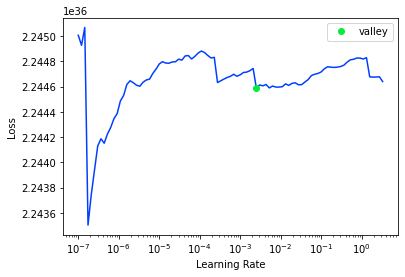

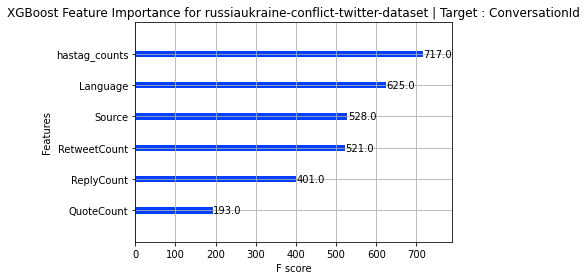

Target Variable: QuoteCount
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
25
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not conv

  2%|▏         | 1/42 [00:00<00:04,  9.32it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.4933443356039532, 'Adjusted R-Squared': 0.4869146951928358, 'RMSE': 0.9132652342725358, 'Time taken': 0.10710549354553223}
{'Model': 'BaggingRegressor', 'R-Squared': 0.2875985569569035, 'Adjusted R-Squared': 0.278557929507118, 'RMSE': 1.0829361952712293, 'Time taken': 0.04142951965332031}
{'Model': 'BayesianRidge', 'R-Squared': 0.10143693144829202, 'Adjusted R-Squared': 0.09003384682200122, 'RMSE': 1.2162273255566343, 'Time taken': 0.010743141174316406}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.1849395953642914, 'Adjusted R-Squared': -0.1999768998739906, 'RMSE': 1.3966531981906694, 'Time taken': 0.012331724166870117}


 17%|█▋        | 7/42 [00:00<00:01, 30.07it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.0194093571913998, 'Adjusted R-Squared': -0.032346024160833986, 'RMSE': 1.2954324808727007, 'Time taken': 0.010292291641235352}
{'Model': 'ElasticNet', 'R-Squared': 0.23145258395218893, 'Adjusted R-Squared': 0.22169944415462783, 'RMSE': 1.1248012948412516, 'Time taken': 0.009990692138671875}
{'Model': 'ElasticNetCV', 'R-Squared': 0.10723731853523766, 'Adjusted R-Squared': 0.0959078428821315, 'RMSE': 1.2122954864473152, 'Time taken': 0.06136608123779297}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.23191964956808042, 'Adjusted R-Squared': -0.247553147659046, 'RMSE': 1.4240710753404002, 'Time taken': 0.012761831283569336}


 24%|██▍       | 10/42 [00:00<00:01, 19.55it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.18047116288002152, 'Adjusted R-Squared': 0.17007105073382878, 'RMSE': 1.1615090398320955, 'Time taken': 0.20905780792236328}
{'Model': 'GammaRegressor', 'R-Squared': 0.15133606834343716, 'Adjusted R-Squared': 0.14056622149500353, 'RMSE': 1.181975152083774, 'Time taken': 0.01406550407409668}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -56400.292872625105, 'Adjusted R-Squared': -57116.045320247256, 'RMSE': 304.70880495784, 'Time taken': 0.38141751289367676}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.217090192866374, 'Adjusted R-Squared': 0.20715478922254615, 'RMSE': 1.1352626265834178, 'Time taken': 0.15132546424865723}


 36%|███▌      | 15/42 [00:01<00:03,  8.33it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2693568939227733, 'Adjusted R-Squared': 0.2600847732872754, 'RMSE': 1.0967133238476305, 'Time taken': 0.395235538482666}
{'Model': 'HuberRegressor', 'R-Squared': 0.04962927677580764, 'Adjusted R-Squared': 0.03756873460291166, 'RMSE': 1.2507974835098787, 'Time taken': 0.0828549861907959}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.24856961703323177, 'Adjusted R-Squared': 0.23903369846766354, 'RMSE': 1.1122050170719426, 'Time taken': 0.01681208610534668}


 48%|████▊     | 20/42 [00:01<00:01, 11.33it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.249354725095425, 'Adjusted R-Squared': -1.2778998358199862, 'RMSE': 1.9242852413259985, 'Time taken': 0.16720151901245117}
{'Model': 'Lars', 'R-Squared': 0.10002382838068546, 'Adjusted R-Squared': 0.08860281097434886, 'RMSE': 1.2171832848296278, 'Time taken': 0.017075300216674805}
{'Model': 'LarsCV', 'R-Squared': 0.101659650119171, 'Adjusted R-Squared': 0.09025939187195231, 'RMSE': 1.2160765886023108, 'Time taken': 0.030893802642822266}
{'Model': 'Lasso', 'R-Squared': 0.11670298292941639, 'Adjusted R-Squared': 0.10549362992090638, 'RMSE': 1.205851578302752, 'Time taken': 0.01543736457824707}
{'Model': 'LassoCV', 'R-Squared': 0.1010350136959921, 'Adjusted R-Squared': 0.08962682859061122, 'RMSE': 1.2164992979539664, 'Time taken': 0.08692526817321777}
{'Model': 'LassoLars', 'R-Squared': -0.0194093571913998, 'Adjusted R-Squared': -0.032346024160833986, 'RMSE': 1.2954324808727007, 'Time taken': 0.012543916702270508}
{'Model': 'LassoLarsCV', 'R-Square

 62%|██████▏   | 26/42 [00:03<00:03,  4.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.15991813231092133, 'Adjusted R-Squared': 0.14925719490369949, 'RMSE': 1.1759836393751777, 'Time taken': 1.8775780200958252}


 67%|██████▋   | 28/42 [00:04<00:03,  3.96it/s]

{'Model': 'NuSVR', 'R-Squared': 0.1354162737247342, 'Adjusted R-Squared': 0.1244443990258094, 'RMSE': 1.1930097763832672, 'Time taken': 0.8404853343963623}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.26092259258416006, 'Adjusted R-Squared': -0.2769241483276139, 'RMSE': 1.440736926418505, 'Time taken': 0.01175689697265625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.09989986133879125, 'Adjusted R-Squared': 0.0884772707466438, 'RMSE': 1.217267112279887, 'Time taken': 0.018064498901367188}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.036756990283661084, 'Adjusted R-Squared': 0.024533094221270924, 'RMSE': 1.2592397001072617, 'Time taken': 0.010561227798461914}
{'Model': 'PoissonRegressor', 'R-Squared': 0.16758694630281656, 'Adjusted R-Squared': 0.15702332887011117, 'RMSE': 1.1706037614900773, 'Time taken': 0.011997461318969727}


 76%|███████▌  | 32/42 [00:33<00:27,  2.71s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04027852128546949, 'Adjusted R-Squared': -0.05348002536269636, 'RMSE': 1.3086252328300039, 'Time taken': 28.439297437667847}
{'Model': 'RANSACRegressor', 'R-Squared': -0.04027852128584497, 'Adjusted R-Squared': -0.0534800253630765, 'RMSE': 1.3086252328302401, 'Time taken': 0.07068538665771484}


 90%|█████████ | 38/42 [00:33<00:05,  1.41s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.3066453921901626, 'Adjusted R-Squared': 0.2978464758473981, 'RMSE': 1.0683613723409582, 'Time taken': 0.292949914932251}
{'Model': 'Ridge', 'R-Squared': 0.10049347256118901, 'Adjusted R-Squared': 0.0890784151063817, 'RMSE': 1.2168656555076136, 'Time taken': 0.010520696640014648}
{'Model': 'RidgeCV', 'R-Squared': 0.10463377045327149, 'Adjusted R-Squared': 0.09327125484988652, 'RMSE': 1.2140618975327782, 'Time taken': 0.013391971588134766}
{'Model': 'SGDRegressor', 'R-Squared': 0.0687596210704563, 'Adjusted R-Squared': 0.05694184976424377, 'RMSE': 1.2381446165700705, 'Time taken': 0.0180203914642334}
{'Model': 'SVR', 'R-Squared': 0.1622122985947959, 'Adjusted R-Squared': 0.1515804749729024, 'RMSE': 1.174376804045496, 'Time taken': 0.12736749649047852}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.1000238283806727, 'Adjusted R-Squared': 0.08860281097433598, 'RMSE': 1.2171832848296364, 'Time taken': 0.012629508972167969}
{'Model': 

100%|██████████| 42/42 [00:34<00:00,  1.23it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.40350970901563554, 'Adjusted R-Squared': 0.39594003527217914, 'RMSE': 0.9909282, 'Time taken': 0.4565439224243164}
{'Model': 'LGBMRegressor', 'R-Squared': 0.25647361221894915, 'Adjusted R-Squared': 0.24703799816081395, 'RMSE': 1.1063401341925738, 'Time taken': 0.09131026268005371}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: QuoteCount
QuoteCount
Target Standard Deviation: 2.283294973826203
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
AdaBoostRegressor                            0.49       0.49   0.91   
XGBRegressor                                 0.40       0.40   0.99   
RandomForestRegressor                        0.30       0.31   1.07   
BaggingRegressor                             0.28       0.29   1.08   
HistGradientBoostingRegressor                0.26       0.27   1.10   
TweedieRegressor  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.4873133897781372.
Better model found at epoch 1 with _rmse value: 1.460553526878357.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       0.99
1       1       1.06
2       1       1.04
3       1       1.20
4       1       1.02
XGBoost RMSE:  0.9909699


<Figure size 432x288 with 0 Axes>

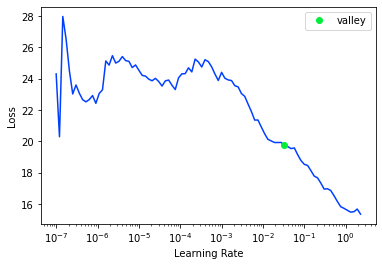

<Figure size 720x720 with 0 Axes>

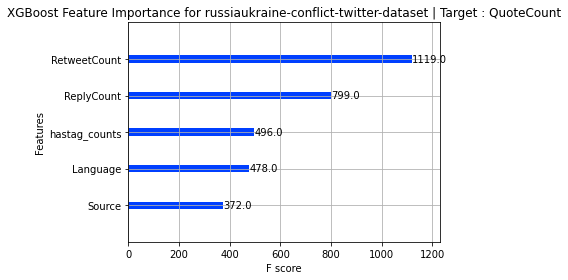

Target Variable: LikeCount
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
24
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not convert Outlinks_n

  2%|▏         | 1/42 [00:00<00:04,  8.45it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.06522926371563831, 'Adjusted R-Squared': 0.05095795476473197, 'RMSE': 70.9632074299735, 'Time taken': 0.11795687675476074}
{'Model': 'BaggingRegressor', 'R-Squared': 0.10388269858604338, 'Adjusted R-Squared': 0.09020151841178448, 'RMSE': 69.48052860793261, 'Time taken': 0.04689216613769531}


 14%|█▍        | 6/42 [00:00<00:01, 28.82it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.24758291179334913, 'Adjusted R-Squared': 0.23609562800393458, 'RMSE': 63.66635812771277, 'Time taken': 0.014250993728637695}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.02675272776386528, 'Adjusted R-Squared': -0.04242834192819922, 'RMSE': 74.37271149570002, 'Time taken': 0.014553308486938477}
{'Model': 'DummyRegressor', 'R-Squared': -0.002711446655006222, 'Adjusted R-Squared': -0.018020018359662826, 'RMSE': 73.49684, 'Time taken': 0.014481067657470703}
{'Model': 'ElasticNet', 'R-Squared': 0.2111782498987177, 'Adjusted R-Squared': 0.19913516974449963, 'RMSE': 65.18836989019968, 'Time taken': 0.022999048233032227}
{'Model': 'ElasticNetCV', 'R-Squared': 0.23434799893799907, 'Adjusted R-Squared': 0.22265865541033492, 'RMSE': 64.22385845751216, 'Time taken': 0.1278667449951172}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.038103630601167726, 'Adjusted R-Squared': 0.02341818984698707, 'RMSE': 71.98546683977952, 'Time taken': 0.0309698581695

 21%|██▏       | 9/42 [00:00<00:02, 11.35it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.1165868667246015, 'Adjusted R-Squared': 0.10309964331581678, 'RMSE': 68.98626119915671, 'Time taken': 0.3102731704711914}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:03,  8.51it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -44.56730070595804, 'Adjusted R-Squared': -45.262984686201676, 'RMSE': 495.45855776430085, 'Time taken': 0.36795783042907715}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.09613458195636826, 'Adjusted R-Squared': 0.0823351099251678, 'RMSE': 69.78025754413554, 'Time taken': 0.13232851028442383}


 31%|███       | 13/42 [00:01<00:04,  6.24it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.14683001450725452, 'Adjusted R-Squared': 0.1338045185455332, 'RMSE': 67.79512518512546, 'Time taken': 0.3898797035217285}
{'Model': 'HuberRegressor', 'R-Squared': 0.14295967171725632, 'Adjusted R-Squared': 0.12987508655263424, 'RMSE': 67.9487249793209, 'Time taken': 0.03478121757507324}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.17936275967003767, 'Adjusted R-Squared': 0.16683394684057262, 'RMSE': 66.49, 'Time taken': 0.026247739791870117}


 45%|████▌     | 19/42 [00:01<00:02, 10.53it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.1947170127011797, 'Adjusted R-Squared': 0.18242261594852593, 'RMSE': 65.86503770576367, 'Time taken': 0.15100479125976562}
{'Model': 'Lars', 'R-Squared': 0.24814317006596187, 'Adjusted R-Squared': 0.23666443983796126, 'RMSE': 63.642650368506985, 'Time taken': 0.036664485931396484}
{'Model': 'LarsCV', 'R-Squared': 0.24830510220589097, 'Adjusted R-Squared': 0.2368288442243015, 'RMSE': 63.63579644025887, 'Time taken': 0.0506131649017334}
{'Model': 'Lasso', 'R-Squared': 0.24749866120935526, 'Adjusted R-Squared': 0.23601009115148286, 'RMSE': 63.66992249233938, 'Time taken': 0.022485733032226562}


 60%|█████▉    | 25/42 [00:02<00:01, 15.89it/s]

{'Model': 'LassoCV', 'R-Squared': 0.24832425879564146, 'Adjusted R-Squared': 0.23684829328107104, 'RMSE': 63.6349855709712, 'Time taken': 0.12485957145690918}
{'Model': 'LassoLars', 'R-Squared': 0.05857239459972985, 'Adjusted R-Squared': 0.04419945405926773, 'RMSE': 71.21543758833569, 'Time taken': 0.01584029197692871}
{'Model': 'LassoLarsCV', 'R-Squared': 0.24830510220589097, 'Adjusted R-Squared': 0.2368288442243015, 'RMSE': 63.63579644025887, 'Time taken': 0.032042741775512695}
{'Model': 'LassoLarsIC', 'R-Squared': 0.24814317006596187, 'Adjusted R-Squared': 0.23666443983796126, 'RMSE': 63.642650368506985, 'Time taken': 0.018513917922973633}
{'Model': 'LinearRegression', 'R-Squared': 0.24814317006595987, 'Adjusted R-Squared': 0.23666443983795926, 'RMSE': 63.64265036850708, 'Time taken': 0.015476703643798828}
{'Model': 'LinearSVR', 'R-Squared': 0.14700623152530357, 'Adjusted R-Squared': 0.13398342589973566, 'RMSE': 67.78812349030362, 'Time taken': 0.03569483757019043}
{'Model': 'MLPReg

 67%|██████▋   | 28/42 [00:04<00:03,  3.82it/s]

{'Model': 'NuSVR', 'R-Squared': 0.03480754793377505, 'Adjusted R-Squared': 0.020071785306809753, 'RMSE': 72.10869588202398, 'Time taken': 0.21350908279418945}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3468986394546254, 'Adjusted R-Squared': 0.33692762631652806, 'RMSE': 59.31587987143708, 'Time taken': 0.013077259063720703}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.24796964547611156, 'Adjusted R-Squared': 0.23648826601773154, 'RMSE': 63.64999413878141, 'Time taken': 0.019709110260009766}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.1720982328280063, 'Adjusted R-Squared': 0.15945851119179266, 'RMSE': 66.78364018612085, 'Time taken': 0.011441469192504883}
{'Model': 'PoissonRegressor', 'R-Squared': -0.40321345989647805, 'Adjusted R-Squared': -0.42463656615443957, 'RMSE': 86.94458796137872, 'Time taken': 0.027377605438232422}


 76%|███████▌  | 32/42 [00:54<00:48,  4.86s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04042635763117253, 'Adjusted R-Squared': -0.05631072950340421, 'RMSE': 74.86629749092339, 'Time taken': 50.51000428199768}


 79%|███████▊  | 33/42 [00:55<00:38,  4.32s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.030289196203103552, 'Adjusted R-Squared': -0.04601880225200583, 'RMSE': 74.50068323142122, 'Time taken': 0.20540738105773926}


 83%|████████▎ | 35/42 [00:55<00:23,  3.29s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.05745469429833039, 'Adjusted R-Squared': 0.043064689631129305, 'RMSE': 71.25769994833027, 'Time taken': 0.41709208488464355}
{'Model': 'Ridge', 'R-Squared': 0.24804108990408413, 'Adjusted R-Squared': 0.23656080120032963, 'RMSE': 63.64697062689559, 'Time taken': 0.014316558837890625}
{'Model': 'RidgeCV', 'R-Squared': 0.24714346181495772, 'Adjusted R-Squared': 0.2356494688655677, 'RMSE': 63.684947614955476, 'Time taken': 0.018347501754760742}
{'Model': 'SGDRegressor', 'R-Squared': 0.24784886215039703, 'Adjusted R-Squared': 0.23636563867177707, 'RMSE': 63.655105334936124, 'Time taken': 0.017731428146362305}


 90%|█████████ | 38/42 [00:55<00:08,  2.17s/it]

{'Model': 'SVR', 'R-Squared': 0.03379068411180386, 'Adjusted R-Squared': 0.019039396846335155, 'RMSE': 72.14667039247766, 'Time taken': 0.22422528266906738}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.24814317006595987, 'Adjusted R-Squared': 0.23666443983795926, 'RMSE': 63.64265036850708, 'Time taken': 0.0128021240234375}
{'Model': 'TweedieRegressor', 'R-Squared': 0.19366669492171684, 'Adjusted R-Squared': 0.18135626278311712, 'RMSE': 65.90797706906692, 'Time taken': 0.015017032623291016}


 98%|█████████▊| 41/42 [00:56<00:01,  1.51s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.07656971638704346, 'Adjusted R-Squared': 0.062471544118143374, 'RMSE': 70.53143, 'Time taken': 0.5745306015014648}


100%|██████████| 42/42 [00:57<00:00,  1.37s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.09753564167645912, 'Adjusted R-Squared': 0.08375755986999278, 'RMSE': 69.72615423304856, 'Time taken': 1.0769124031066895}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: LikeCount
LikeCount
Target Standard Deviation: 55.7611083984375
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
OrthogonalMatchingPursuit                    0.34       0.35  59.32   
LassoCV                                      0.24       0.25  63.63   
LassoLarsCV                                  0.24       0.25  63.64   
LarsCV                                       0.24       0.25  63.64   
LassoLarsIC                                  0.24       0.25  63.64   
Lars                                         0.24       0.25  63.64   
LinearRegression                             0.24       0.25  63.64   
TransformedTargetRegressor           

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 74.3196029663086.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   49.00      42.45
1    0.00       0.46
2    1.00       0.02
3    0.00       0.55
4    0.00      -0.93
XGBoost RMSE:  70.51082


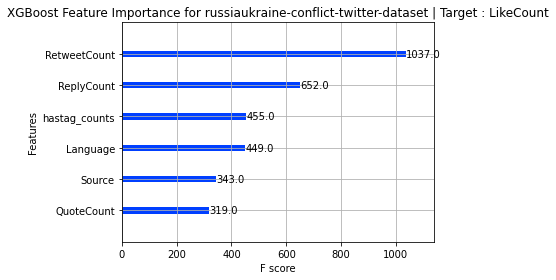

Target Variable: RetweetCount
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
25
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not co

 10%|▉         | 4/42 [00:00<00:01, 37.81it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.9939568223463024, 'Adjusted R-Squared': -2.031951198264403, 'RMSE': 5.414015798623582, 'Time taken': 0.04267597198486328}
{'Model': 'BaggingRegressor', 'R-Squared': -1.3787635304123218, 'Adjusted R-Squared': -1.4089508848591787, 'RMSE': 4.825834102654915, 'Time taken': 0.040515899658203125}
{'Model': 'BayesianRidge', 'R-Squared': -0.10415701403851707, 'Adjusted R-Squared': -0.11816915888672175, 'RMSE': 3.2878513204993403, 'Time taken': 0.010727167129516602}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.4153123951643107, 'Adjusted R-Squared': -1.445963567691777, 'RMSE': 4.862766402065281, 'Time taken': 0.011566162109375}
{'Model': 'DummyRegressor', 'R-Squared': -0.18874917089015275, 'Adjusted R-Squared': -0.20383482026693156, 'RMSE': 3.4114724299963206, 'Time taken': 0.010328054428100586}
{'Model': 'ElasticNet', 'R-Squared': -0.0663872626091504, 'Adjusted R-Squared': -0.07992009589099247, 'RMSE': 3.231128476684089, 'Time taken': 0.0096

 21%|██▏       | 9/42 [00:00<00:01, 20.02it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -1.3483326688388364, 'Adjusted R-Squared': -1.3781338448393297, 'RMSE': 4.794866967291192, 'Time taken': 0.2165846824645996}
{'Model': 'GammaRegressor', 'R-Squared': 0.006034917394381889, 'Adjusted R-Squared': -0.006578852689445913, 'RMSE': 3.119480796173922, 'Time taken': 0.014151573181152344}


 29%|██▊       | 12/42 [00:00<00:02, 10.39it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -107258.8134482739, 'Adjusted R-Squared': -108619.97859355657, 'RMSE': 1024.743732958699, 'Time taken': 0.3762855529785156}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.6928291339091803, 'Adjusted R-Squared': -0.7143117371313783, 'RMSE': 4.071020737858292, 'Time taken': 0.14614367485046387}


 33%|███▎      | 14/42 [00:01<00:03,  8.06it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -1.241939043121386, 'Adjusted R-Squared': -1.2703900462066828, 'RMSE': 4.68498982974351, 'Time taken': 0.3855321407318115}
{'Model': 'HuberRegressor', 'R-Squared': 0.05791094366298499, 'Adjusted R-Squared': 0.04595549878561167, 'RMSE': 3.036985593602126, 'Time taken': 0.024817943572998047}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.7321019203428925, 'Adjusted R-Squared': -0.7540829091797314, 'RMSE': 4.117972802241414, 'Time taken': 0.0155792236328125}


 45%|████▌     | 19/42 [00:01<00:02, 11.46it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.6898037714833849, 'Adjusted R-Squared': -0.7112479817813975, 'RMSE': 4.067381321254701, 'Time taken': 0.16800332069396973}
{'Model': 'Lars', 'R-Squared': -0.10289722866221962, 'Adjusted R-Squared': -0.11689338638635949, 'RMSE': 3.2859751520367, 'Time taken': 0.03354239463806152}
{'Model': 'LarsCV', 'R-Squared': -0.07006199165441918, 'Adjusted R-Squared': -0.08364145855358696, 'RMSE': 3.2366908604170446, 'Time taken': 0.059365034103393555}
{'Model': 'Lasso', 'R-Squared': 0.05859964776232551, 'Adjusted R-Squared': 0.04665294278469001, 'RMSE': 3.03587531277928, 'Time taken': 0.01660776138305664}
{'Model': 'LassoCV', 'R-Squared': -0.06972933180646579, 'Adjusted R-Squared': -0.08330457713395911, 'RMSE': 3.236187711630759, 'Time taken': 0.06348419189453125}
{'Model': 'LassoLars', 'R-Squared': -0.18874917089015275, 'Adjusted R-Squared': -0.20383482026693156, 'RMSE': 3.4114724299963206, 'Time taken': 0.01030588150024414}


 52%|█████▏    | 22/42 [00:01<00:01, 14.51it/s]

{'Model': 'LassoLarsCV', 'R-Squared': -0.07006199165441918, 'Adjusted R-Squared': -0.08364145855358696, 'RMSE': 3.2366908604170446, 'Time taken': 0.021461963653564453}
{'Model': 'LassoLarsIC', 'R-Squared': -0.09183595211833184, 'Adjusted R-Squared': -0.10569173831272693, 'RMSE': 3.269455628426818, 'Time taken': 0.014123916625976562}
{'Model': 'LinearRegression', 'R-Squared': -0.10289722866221895, 'Adjusted R-Squared': -0.11689338638635882, 'RMSE': 3.2859751520366993, 'Time taken': 0.010042190551757812}
{'Model': 'LinearSVR', 'R-Squared': 0.0645897235970111, 'Adjusted R-Squared': 0.05271903481017104, 'RMSE': 3.0262013502475567, 'Time taken': 0.020237207412719727}


 62%|██████▏   | 26/42 [00:03<00:03,  4.46it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3808451633229042, 'Adjusted R-Squared': -0.3983685791011138, 'RMSE': 3.676793539205022, 'Time taken': 1.8086152076721191}


 67%|██████▋   | 28/42 [00:03<00:02,  4.93it/s]

{'Model': 'NuSVR', 'R-Squared': 0.1415731560406751, 'Adjusted R-Squared': 0.13067941436606434, 'RMSE': 2.8990012148850517, 'Time taken': 0.23582816123962402}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.04031338174104826, 'Adjusted R-Squared': 0.02813461754994473, 'RMSE': 3.065218738747422, 'Time taken': 0.012672901153564453}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.10181767714251255, 'Adjusted R-Squared': -0.11580013497427033, 'RMSE': 3.284366548862048, 'Time taken': 0.01924276351928711}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.19238577254630895, 'Adjusted R-Squared': -0.20751757169029772, 'RMSE': 3.416686605069365, 'Time taken': 0.011081457138061523}
{'Model': 'PoissonRegressor', 'R-Squared': 0.048237159173848965, 'Adjusted R-Squared': 0.03615895053392315, 'RMSE': 3.0525383214433965, 'Time taken': 0.015037775039672852}


 76%|███████▌  | 32/42 [00:41<00:37,  3.74s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1120764997445951, 'Adjusted R-Squared': -0.12618914568044026, 'RMSE': 3.299621190553, 'Time taken': 37.443713903427124}
{'Model': 'RANSACRegressor', 'R-Squared': -0.112076499627499, 'Adjusted R-Squared': -0.12618914556185823, 'RMSE': 3.2996211903792836, 'Time taken': 0.08845162391662598}


 81%|████████  | 34/42 [00:41<00:23,  2.97s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -1.1909719076421155, 'Adjusted R-Squared': -1.2187761196680307, 'RMSE': 4.631430559256913, 'Time taken': 0.2794034481048584}
{'Model': 'Ridge', 'R-Squared': -0.10329633491357582, 'Adjusted R-Squared': -0.11729755743785986, 'RMSE': 3.2865696474113464, 'Time taken': 0.010752201080322266}
{'Model': 'RidgeCV', 'R-Squared': -0.10681848858707688, 'Adjusted R-Squared': -0.1208644084930044, 'RMSE': 3.291811475506165, 'Time taken': 0.010364055633544922}
{'Model': 'SGDRegressor', 'R-Squared': -0.1115116600578634, 'Adjusted R-Squared': -0.1256171379773796, 'RMSE': 3.2987831215364283, 'Time taken': 0.013113975524902344}


 90%|█████████ | 38/42 [00:41<00:07,  1.86s/it]

{'Model': 'SVR', 'R-Squared': 0.15320060021097737, 'Adjusted R-Squared': 0.14245441493446687, 'RMSE': 2.8793007017830266, 'Time taken': 0.20975685119628906}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.10289722866221895, 'Adjusted R-Squared': -0.11689338638635882, 'RMSE': 3.2859751520366993, 'Time taken': 0.012380361557006836}
{'Model': 'TweedieRegressor', 'R-Squared': -0.09252563373449996, 'Adjusted R-Squared': -0.10639017223366887, 'RMSE': 3.270488076324997, 'Time taken': 0.011234045028686523}


100%|██████████| 42/42 [00:42<00:00,  1.01s/it]

{'Model': 'XGBRegressor', 'R-Squared': -1.5749188680086026, 'Adjusted R-Squared': -1.6075955033894225, 'RMSE': 5.0208645, 'Time taken': 0.4877939224243164}
{'Model': 'LGBMRegressor', 'R-Squared': -1.213177326149578, 'Adjusted R-Squared': -1.2412633328266032, 'RMSE': 4.654841080528702, 'Time taken': 0.10150432586669922}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: RetweetCount
RetweetCount
Target Standard Deviation: 7.409543017917838
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
SVR                                          0.14       0.15    2.88   
NuSVR                                        0.13       0.14    2.90   
LinearSVR                                    0.05       0.06    3.03   
Lasso                                        0.05       0.06    3.04   
HuberRegressor                               0.05       0.06    3.04   
PoissonRe

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.1352641582489014.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       7       1.66
1       7      16.06
2      16      36.92
3       0      14.56
4       2       1.98
XGBoost RMSE:  5.0207863


<Figure size 432x288 with 0 Axes>

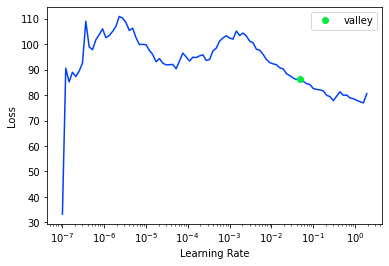

<Figure size 720x720 with 0 Axes>

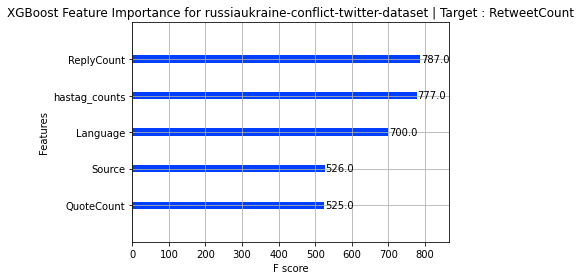

Target Variable: ReplyCount
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Tweet Id', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
25
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not conv

  5%|▍         | 2/42 [00:00<00:02, 16.01it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -1.2585352145880457, 'Adjusted R-Squared': -1.2871968289863713, 'RMSE': 1.362327859490011, 'Time taken': 0.08303713798522949}
{'Model': 'BaggingRegressor', 'R-Squared': 0.36062139920870007, 'Adjusted R-Squared': 0.3525074575742927, 'RMSE': 0.7248485145766635, 'Time taken': 0.04170942306518555}
{'Model': 'BayesianRidge', 'R-Squared': 0.4536082318600917, 'Adjusted R-Squared': 0.44667432617303693, 'RMSE': 0.6700701608939311, 'Time taken': 0.011877298355102539}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.06194962401724302, 'Adjusted R-Squared': -0.07542614208852783, 'RMSE': 0.9341576239323958, 'Time taken': 0.012065649032592773}
{'Model': 'DummyRegressor', 'R-Squared': -0.02670055674290195, 'Adjusted R-Squared': -0.039729751625426246, 'RMSE': 0.9185231437612228, 'Time taken': 0.009186267852783203}
{'Model': 'ElasticNet', 'R-Squared': 0.311266128087226, 'Adjusted R-Squared': 0.302525850524881, 'RMSE': 0.7523049612076359, 'Time taken': 0.009

 17%|█▋        | 7/42 [00:00<00:01, 32.55it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4540798232004657, 'Adjusted R-Squared': 0.4471519021750908, 'RMSE': 0.6697809293223511, 'Time taken': 0.0648503303527832}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.8964344635902719, 'Adjusted R-Squared': -0.9205008907931944, 'RMSE': 1.248352180972945, 'Time taken': 0.011850357055664062}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.2682957678679564, 'Adjusted R-Squared': 0.259010181165773, 'RMSE': 0.7754181965901084, 'Time taken': 0.21951055526733398}
{'Model': 'GammaRegressor', 'R-Squared': 0.21150392998483758, 'Adjusted R-Squared': 0.20149763468007653, 'RMSE': 0.8049482700363559, 'Time taken': 0.013650178909301758}


 26%|██▌       | 11/42 [00:00<00:02, 10.96it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -38671.99753691408, 'Adjusted R-Squared': -39162.771617331775, 'RMSE': 178.26747886175016, 'Time taken': 0.38788747787475586}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.4879864870936722, 'Adjusted R-Squared': 0.48148885368115535, 'RMSE': 0.6486477504364901, 'Time taken': 0.12331151962280273}


 33%|███▎      | 14/42 [00:01<00:03,  7.99it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2971727828744455, 'Adjusted R-Squared': 0.28825365575356277, 'RMSE': 0.7599630734468731, 'Time taken': 0.39270639419555664}
{'Model': 'HuberRegressor', 'R-Squared': 0.44442074883117444, 'Adjusted R-Squared': 0.4373702507198949, 'RMSE': 0.6756802330079389, 'Time taken': 0.05467653274536133}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.26084013416591245, 'Adjusted R-Squared': 0.2514599328228402, 'RMSE': 0.7793587107359485, 'Time taken': 0.014063358306884766}


 48%|████▊     | 20/42 [00:01<00:01, 11.91it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.129697867474492, 'Adjusted R-Squared': -2.169414845488128, 'RMSE': 1.6036862729304293, 'Time taken': 0.16426444053649902}
{'Model': 'Lars', 'R-Squared': 0.45386584759780413, 'Adjusted R-Squared': 0.44693521114599954, 'RMSE': 0.6699121781234104, 'Time taken': 0.017017602920532227}
{'Model': 'LarsCV', 'R-Squared': 0.45386584759780413, 'Adjusted R-Squared': 0.44693521114599954, 'RMSE': 0.6699121781234104, 'Time taken': 0.02971339225769043}
{'Model': 'Lasso', 'R-Squared': 0.14435746584299103, 'Adjusted R-Squared': 0.13349905804912032, 'RMSE': 0.8385218570065325, 'Time taken': 0.014865636825561523}
{'Model': 'LassoCV', 'R-Squared': 0.4541607991897392, 'Adjusted R-Squared': 0.44723390577844135, 'RMSE': 0.6697312533926029, 'Time taken': 0.08002448081970215}
{'Model': 'LassoLars', 'R-Squared': -0.02670055674290195, 'Adjusted R-Squared': -0.039729751625426246, 'RMSE': 0.9185231437612228, 'Time taken': 0.01086115837097168}
{'Model': 'LassoLarsCV', 'R-Squa

 62%|██████▏   | 26/42 [00:03<00:03,  5.00it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.41771998522540466, 'Adjusted R-Squared': 0.41033064493638693, 'RMSE': 0.691726075040497, 'Time taken': 1.9045071601867676}


 67%|██████▋   | 28/42 [00:04<00:02,  5.01it/s]

{'Model': 'NuSVR', 'R-Squared': 0.24419100964569473, 'Adjusted R-Squared': 0.23459952499652836, 'RMSE': 0.7880871233673729, 'Time taken': 0.37787866592407227}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.39469946232966535, 'Adjusted R-Squared': 0.3870179834252194, 'RMSE': 0.7052672782018439, 'Time taken': 0.011823654174804688}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.45584571504855587, 'Adjusted R-Squared': 0.44894020381820754, 'RMSE': 0.6686967793361713, 'Time taken': 0.01778244972229004}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.19804156225716563, 'Adjusted R-Squared': -0.21324513538225665, 'RMSE': 0.9922112507047386, 'Time taken': 0.010750770568847656}
{'Model': 'PoissonRegressor', 'R-Squared': 0.22517640674684003, 'Adjusted R-Squared': 0.21534362003042928, 'RMSE': 0.7979388730399882, 'Time taken': 0.012327432632446289}


 76%|███████▌  | 32/42 [00:33<00:26,  2.67s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.14695122419198037, 'Adjusted R-Squared': -0.161506442773097, 'RMSE': 0.9708243919652043, 'Time taken': 29.691792726516724}
{'Model': 'RANSACRegressor', 'R-Squared': -0.14695122414986428, 'Adjusted R-Squared': -0.16150644273044645, 'RMSE': 0.9708243919473799, 'Time taken': 0.06177043914794922}


 81%|████████  | 34/42 [00:34<00:17,  2.18s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.31057987208859006, 'Adjusted R-Squared': 0.30183088569377514, 'RMSE': 0.7526796670798286, 'Time taken': 0.2889378070831299}
{'Model': 'Ridge', 'R-Squared': 0.45382251240740024, 'Adjusted R-Squared': 0.4468913260166312, 'RMSE': 0.6699387560217138, 'Time taken': 0.011492252349853516}
{'Model': 'RidgeCV', 'R-Squared': 0.45343571466815735, 'Adjusted R-Squared': 0.44649961967663643, 'RMSE': 0.6701759361874002, 'Time taken': 0.012214899063110352}
{'Model': 'SGDRegressor', 'R-Squared': 0.45506006030357005, 'Adjusted R-Squared': 0.4481445788353412, 'RMSE': 0.6691793403646875, 'Time taken': 0.01745462417602539}


 90%|█████████ | 38/42 [00:34<00:05,  1.42s/it]

{'Model': 'SVR', 'R-Squared': 0.28776205010148237, 'Adjusted R-Squared': 0.27872349743779556, 'RMSE': 0.7650340409693676, 'Time taken': 0.1685047149658203}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.453865847597806, 'Adjusted R-Squared': 0.44693521114600143, 'RMSE': 0.6699121781234092, 'Time taken': 0.01287221908569336}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3865045437324408, 'Adjusted R-Squared': 0.3787190683990961, 'RMSE': 0.7100253916876953, 'Time taken': 0.011094331741333008}


100%|██████████| 42/42 [00:35<00:00,  1.20it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.4264993314507407, 'Adjusted R-Squared': 0.41922140418488707, 'RMSE': 0.6864915, 'Time taken': 0.4580693244934082}
{'Model': 'LGBMRegressor', 'R-Squared': 0.26031101378069665, 'Adjusted R-Squared': 0.2509240977119237, 'RMSE': 0.7796376090014826, 'Time taken': 0.08991718292236328}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: ReplyCount
ReplyCount
Target Standard Deviation: 1.5580375025573037
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GradientBoostingRegressor                    0.48       0.49   0.65   
OrthogonalMatchingPursuitCV                  0.45       0.46   0.67   
SGDRegressor                                 0.45       0.46   0.67   
LassoCV                                      0.45       0.45   0.67   
ElasticNetCV                                 0.45       0.45   0.67   
LinearRegression   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.1512713432312012.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.06
1       1       1.23
2       1       1.13
3       1       1.26
4       1       1.13
XGBoost RMSE:  0.68976206


<Figure size 432x288 with 0 Axes>

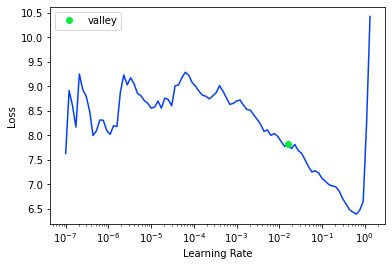

<Figure size 720x720 with 0 Axes>

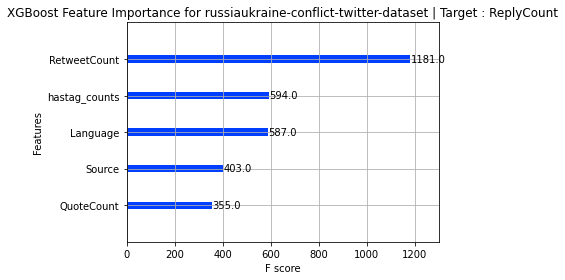

Target Variable: Tweet Id
CATS=====================
['ReplyCount', 'RetweetCount', 'QuoteCount', 'Language', 'Source', 'hastag_counts']
CONTS=====================
['Datetime', 'Text', 'Username', 'Permalink', 'User', 'Outlinks', 'CountLinks', 'LikeCount', 'ConversationId', 'Media', 'QuotedTweet', 'MentionedUsers', 'hashtag', 'first_hashtag', 'Text_no_dollar', 'Text_no_percent', 'Outlinks_no_percent', 'Text_no_dollar_no_percent']
24
Could not convert Datetime to float.
Could not convert Text to float.
Could not convert Username to float.
Could not convert Permalink to float.
Could not convert User to float.
Could not convert Outlinks to float.
Could not convert CountLinks to float.
Could not convert Media to float.
Could not convert QuotedTweet to float.
Could not convert MentionedUsers to float.
Could not convert hashtag to float.
Could not convert first_hashtag to float.
Could not convert Text_no_dollar to float.
Could not convert Text_no_percent to float.
Could not convert Outlinks_n

 10%|▉         | 4/42 [00:00<00:01, 33.15it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.14568654282838644, 'Adjusted R-Squared': 0.13264358928378162, 'RMSE': 1057301784283299.0, 'Time taken': 0.03441262245178223}
{'Model': 'BaggingRegressor', 'R-Squared': 0.17418720956560618, 'Adjusted R-Squared': 0.16157938070401234, 'RMSE': 1039515917780047.1, 'Time taken': 0.04664897918701172}
{'Model': 'BayesianRidge', 'R-Squared': -0.0018193690481775882, 'Adjusted R-Squared': -0.01711432124738632, 'RMSE': 1144946129783212.5, 'Time taken': 0.017329931259155273}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.08957176315231741, 'Adjusted R-Squared': -0.10620644655922296, 'RMSE': 1194038310469279.8, 'Time taken': 0.021901369094848633}
{'Model': 'DummyRegressor', 'R-Squared': -0.0018270780038365242, 'Adjusted R-Squared': -0.01712214789702493, 'RMSE': 1144950500000000.0, 'Time taken': 0.01551198959350586}
{'Model': 'ElasticNet', 'R-Squared': 0.08117927790615498, 'Adjusted R-Squared': 0.06715148062227949, 'RMSE': 1096492668062729.8, 'Time ta

 19%|█▉        | 8/42 [00:00<00:01, 25.91it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0018193690473076174, 'Adjusted R-Squared': -0.01711432124650325, 'RMSE': 1144946129782715.2, 'Time taken': 0.11443948745727539}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.03004235787706455, 'Adjusted R-Squared': -0.045768195401905354, 'RMSE': 1160961675712683.0, 'Time taken': 0.019562244415283203}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.1280930181135833, 'Adjusted R-Squared': 0.11478146113821819, 'RMSE': 1068133212130213.0, 'Time taken': 0.30458712577819824}
{'Model': 'GammaRegressor', 'R-Squared': 0.06361070985206574, 'Adjusted R-Squared': 0.049314690155150664, 'RMSE': 1106925928239422.6, 'Time taken': 0.016574382781982422}


 26%|██▌       | 11/42 [00:01<00:03,  8.46it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -42770.923030563026, 'Adjusted R-Squared': -43423.92948904491, 'RMSE': 2.3657547988187312e+17, 'Time taken': 0.4061293601989746}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.2566337794556527, 'Adjusted R-Squared': 0.24528467685192212, 'RMSE': 986260755954872.2, 'Time taken': 0.1499464511871338}


 31%|███       | 13/42 [00:01<00:04,  6.13it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.23526988396742632, 'Adjusted R-Squared': 0.22359461502036415, 'RMSE': 1000332636535714.1, 'Time taken': 0.41616058349609375}
{'Model': 'HuberRegressor', 'R-Squared': -1715776.8892306348, 'Adjusted R-Squared': -1741971.9715089651, 'RMSE': 1.4983762299918438e+18, 'Time taken': 0.0233609676361084}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1372661174162325, 'Adjusted R-Squared': 0.12409460775846504, 'RMSE': 1062499600000000.0, 'Time taken': 0.02866959571838379}


 48%|████▊     | 20/42 [00:01<00:02, 10.52it/s]

{'Model': 'KernelRidge', 'R-Squared': -1715710.4488904942, 'Adjusted R-Squared': -1741904.5168124866, 'RMSE': 1.4983472187804362e+18, 'Time taken': 0.16261816024780273}
{'Model': 'Lars', 'R-Squared': 0.08043033015017087, 'Adjusted R-Squared': 0.06639109854941005, 'RMSE': 1096939462755424.1, 'Time taken': 0.0185089111328125}
{'Model': 'LarsCV', 'R-Squared': 0.08247663766378033, 'Adjusted R-Squared': 0.06846864739910519, 'RMSE': 1095718279797756.5, 'Time taken': 0.032119035720825195}
{'Model': 'Lasso', 'R-Squared': 0.08043033015017031, 'Adjusted R-Squared': 0.0663910985494095, 'RMSE': 1096939462755424.5, 'Time taken': 0.02233123779296875}
{'Model': 'LassoCV', 'R-Squared': 0.08250314137946801, 'Adjusted R-Squared': 0.06849555575167365, 'RMSE': 1095702454143242.1, 'Time taken': 0.10166740417480469}


 57%|█████▋    | 24/42 [00:02<00:01, 14.06it/s]

{'Model': 'LassoLars', 'R-Squared': 0.0804303301502034, 'Adjusted R-Squared': 0.06639109854944314, 'RMSE': 1096939462755404.8, 'Time taken': 0.02475714683532715}
{'Model': 'LassoLarsCV', 'R-Squared': 0.08247663766378033, 'Adjusted R-Squared': 0.06846864739910519, 'RMSE': 1095718279797756.5, 'Time taken': 0.034749746322631836}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0825422127775679, 'Adjusted R-Squared': 0.06853522365966813, 'RMSE': 1095679123773136.4, 'Time taken': 0.025302648544311523}
{'Model': 'LinearRegression', 'R-Squared': 0.08043033015017187, 'Adjusted R-Squared': 0.06639109854941116, 'RMSE': 1096939462755423.6, 'Time taken': 0.03045034408569336}
{'Model': 'LinearSVR', 'R-Squared': -1715776.8892306418, 'Adjusted R-Squared': -1741971.971508972, 'RMSE': 1.498376229991847e+18, 'Time taken': 0.016907691955566406}


 64%|██████▍   | 27/42 [00:02<00:01,  8.99it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1715776.8892306455, 'Adjusted R-Squared': -1741971.971508976, 'RMSE': 1.4983762299918484e+18, 'Time taken': 0.4177725315093994}
{'Model': 'NuSVR', 'R-Squared': -1.7533467133734604e-06, 'Adjusted R-Squared': -0.015268955687884667, 'RMSE': 1143907011897108.0, 'Time taken': 0.1966261863708496}


 71%|███████▏  | 30/42 [00:02<00:01, 10.76it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.05337807047011944, 'Adjusted R-Squared': 0.03892582727118998, 'RMSE': 1112957606421424.5, 'Time taken': 0.015148401260375977}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.08014332272876923, 'Adjusted R-Squared': 0.06609970933531528, 'RMSE': 1097110632605501.1, 'Time taken': 0.017496347427368164}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1715776.8892269812, 'Adjusted R-Squared': -1741971.9715052557, 'RMSE': 1.4983762299902484e+18, 'Time taken': 0.1092984676361084}
{'Model': 'PoissonRegressor', 'R-Squared': 0.08045471320867192, 'Adjusted R-Squared': 0.06641585386834625, 'RMSE': 1096924919585246.9, 'Time taken': 0.036087989807128906}


 76%|███████▌  | 32/42 [00:24<00:23,  2.38s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -1715776.8993259836, 'Adjusted R-Squared': -1741971.9817584413, 'RMSE': 1.4983762343999409e+18, 'Time taken': 21.39435338973999}
{'Model': 'RANSACRegressor', 'R-Squared': -0.20364706420619227, 'Adjusted R-Squared': -0.2220233552627755, 'RMSE': 1254989007537185.5, 'Time taken': 0.08948373794555664}


 81%|████████  | 34/42 [00:24<00:14,  1.87s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.19645816020495543, 'Adjusted R-Squared': 0.1841903458569395, 'RMSE': 1025403012313380.4, 'Time taken': 0.3549666404724121}
{'Model': 'Ridge', 'R-Squared': 0.0805086319833026, 'Adjusted R-Squared': 0.06647059583037596, 'RMSE': 1096892759279816.2, 'Time taken': 0.012176513671875}
{'Model': 'RidgeCV', 'R-Squared': 0.08117403139969193, 'Adjusted R-Squared': 0.06714615401648105, 'RMSE': 1096495798568779.1, 'Time taken': 0.02008366584777832}


 88%|████████▊ | 37/42 [00:25<00:06,  1.27s/it]

{'Model': 'SGDRegressor', 'R-Squared': -1714403.461156035, 'Adjusted R-Squared': -1740577.5750668142, 'RMSE': 1.4977764076073682e+18, 'Time taken': 0.20151829719543457}
{'Model': 'SVR', 'R-Squared': -0.0033296355250489462, 'Adjusted R-Squared': -0.018647645227721554, 'RMSE': 1145808821506479.8, 'Time taken': 0.19055843353271484}


 93%|█████████▎| 39/42 [00:25<00:02,  1.01it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.08043033015017187, 'Adjusted R-Squared': 0.06639109854941116, 'RMSE': 1096939462755423.6, 'Time taken': 0.012964248657226562}
{'Model': 'TweedieRegressor', 'R-Squared': -0.0018193690481396185, 'Adjusted R-Squared': -0.017114321247347908, 'RMSE': 1144946129783190.8, 'Time taken': 0.022426843643188477}


100%|██████████| 42/42 [00:26<00:00,  1.56it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.21063430427766727, 'Adjusted R-Squared': 0.19858291961015073, 'RMSE': 1016317640000000.0, 'Time taken': 1.4842491149902344}
{'Model': 'LGBMRegressor', 'R-Squared': 0.24009140539481988, 'Adjusted R-Squared': 0.2284897474619163, 'RMSE': 997174168279215.2, 'Time taken': 0.101898193359375}
Project: russiaukraine-conflict-twitter-dataset
russiaukraine-conflict-twitter-dataset
Target: Tweet Id
Tweet Id
Target Standard Deviation: 1146228792360960.0
                               Adjusted R-Squared   R-Squared  \
Model                                                           
GradientBoostingRegressor                    0.25        0.26   
LGBMRegressor                                0.23        0.24   
HistGradientBoostingRegressor                0.22        0.24   
XGBRegressor                                 0.20        0.21   
RandomForestRegressor                        0.18        0.20   
BaggingRegressor                             0.16        0

LEARNING RATE: 0.1


No improvement since epoch -1: early stopping
Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/1746676157.py", line 294, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 195, in _with_events
    self(f'after_{event_type}');  final()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 171, in __call__
    def __call__(self, event_name): L(event_name).map(self._call_one)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/foundation.py", line 156, in map
    def map(self, f, *args, gen=False, **kwargs): return self._new(map_ex(self, f, *args

XGBoost Predictions vs Actual==========
                  actual              predicted
0 1499707334568443904.00 1497308887391404032.00
1 1496954844647260160.00 1498479454958125056.00
2 1498974097751670784.00 1498852326838894592.00
3 1499702111888211968.00 1498479454958125056.00
4 1499716268100419584.00 1498317964187795456.00
XGBoost RMSE:  1014150200000000.0


<Figure size 432x288 with 0 Axes>

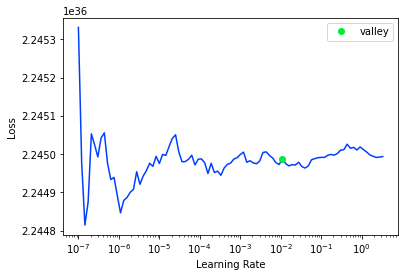

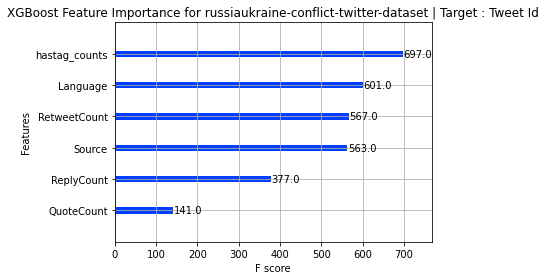

<Figure size 432x288 with 0 Axes>

In [26]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

        feature  importance
0    ReplyCount      401.00
1  RetweetCount      521.00
2    QuoteCount      193.00
3      Language      625.00
4        Source      528.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

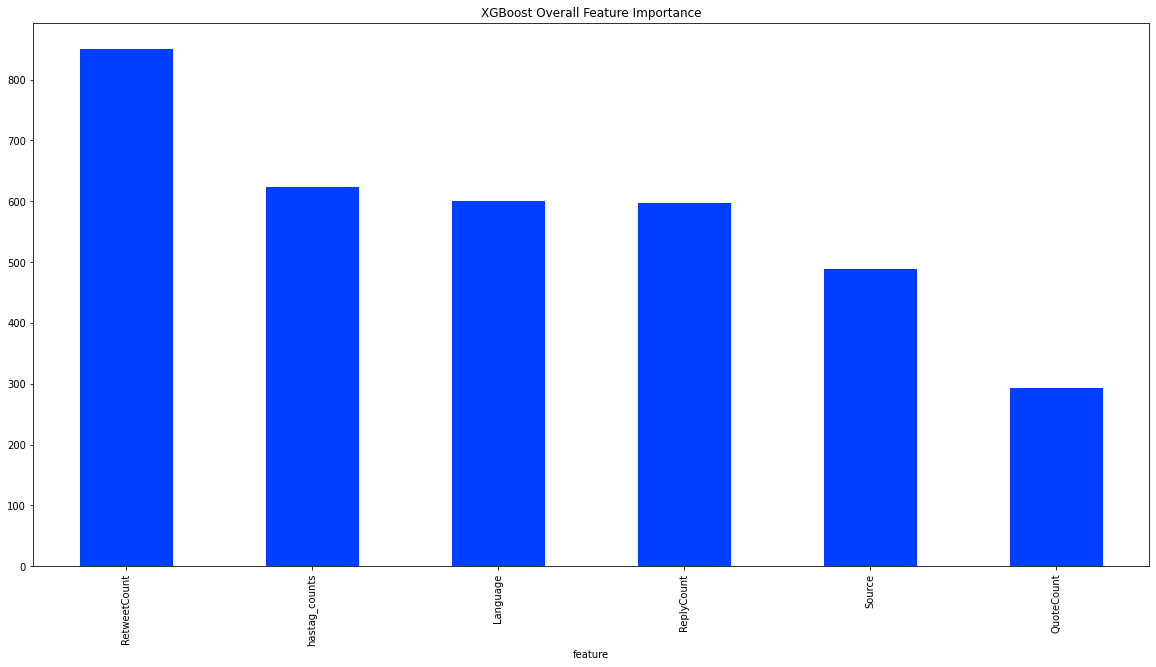

In [27]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [28]:
df.isna().sum()

Datetime                     0
Tweet Id                     0
Text                         0
Username                     0
Permalink                    0
User                         0
Outlinks                     0
CountLinks                   0
ReplyCount                   0
RetweetCount                 0
LikeCount                    0
QuoteCount                   0
ConversationId               0
Language                     0
Source                       0
Media                        0
QuotedTweet                  0
MentionedUsers               0
hashtag                      0
hastag_counts                0
first_hashtag                0
Text_no_dollar               0
Text_no_percent              0
Outlinks_no_percent          0
Text_no_dollar_no_percent    0
dtype: int64

# **To Be Continued...**